# 优化算法

优化算法的目标在于降低训练误差，而深度学习的目标在于降低泛化误差。

深度学习中绝大多数目标函数都很复杂，很多优化问题不存在解析解，而需要基于数值方法的优化算法找到近似解，即数值解。

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import d2l_pytorch as d2l

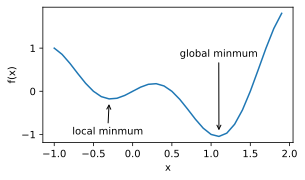

In [2]:
def f(x):
    return x * np.cos(np.pi * x)

d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minmum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0), arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minmum',  xy=(1.1, -0.95), xytext=(0.6, 0.8), arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

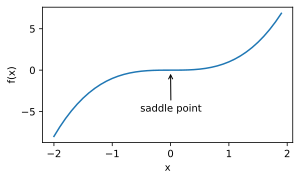

In [3]:
# 鞍点

x = np.arange(-2.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0), arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)');

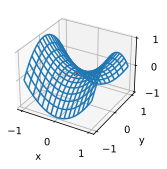

In [4]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

假设一个函数的输入为kk维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有k个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

* 当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。

* 当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。

* 当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5。那么，以上第一种情况的概率为$0.5^k$。由于深度学习模型参数通常都是高维的（k很大），目标函数的鞍点通常比局部最小值更常见。

## 梯度下降和随机梯度下降

In [5]:
import numpy as np
import torch
import math
import d2l_pytorch as d2l

In [6]:
def gd(eta):
    x = 10
    result = [x]
    for i in range(10):
        x -= eta * 2 * x
        result.append(x)
    print('epoch 10, x: ', x)
    return result

In [7]:
res = gd(0.2)

epoch 10, x:  0.06046617599999997


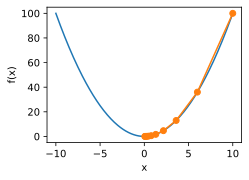

In [8]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line, [x * x for x in f_line])
    d2l.plt.plot(res, [x * x for x in res], '-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')

show_trace(res)

epoch 10, x:  3.4867844009999995


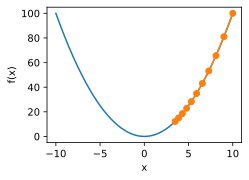

In [9]:
show_trace(gd(0.05))

epoch 10, x:  61.917364224000096


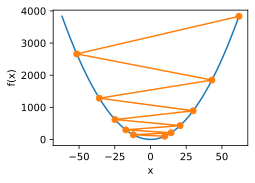

In [10]:
show_trace(gd(1.1))

In [11]:
def train_2d(trainer):
    x1, x2, s1, s2 = -5, -2, 0, 0 # s1和s2是自变量状态
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1 -0.057646, x2 -0.000073


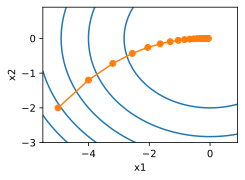

In [12]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

epoch 20, x1 -0.157338, x2 0.090210


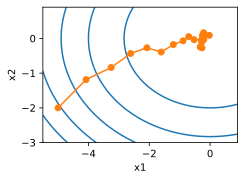

In [13]:
# 随机梯度下降
# 通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

随机梯度下降中自变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的无意义的干扰。

## 小批量随机梯度下降

In [14]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import d2l_pytorch as d2l

def get_data_ch7():
    data = np.genfromtxt('./data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape

torch.Size([1500, 5])

In [15]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [16]:
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.245692, 0.048764 sec per epoch


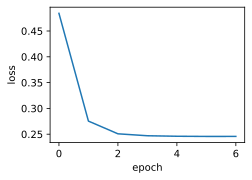

In [17]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.244421, 0.326973 sec per epoch


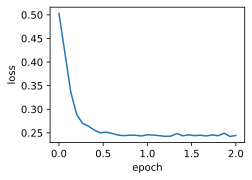

In [18]:
train_sgd(0.005, 1)

loss: 0.246307, 0.043004 sec per epoch


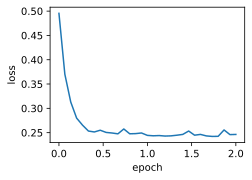

In [19]:
train_sgd(0.05, 10)

In [20]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.248045, 0.039667 sec per epoch


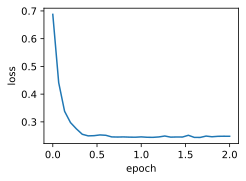

In [21]:
train_pytorch_ch7(optim.SGD, {'lr': 0.05}, features, labels, 10)

## 动量法

epoch 20, x1 -0.943467, x2 -0.000073


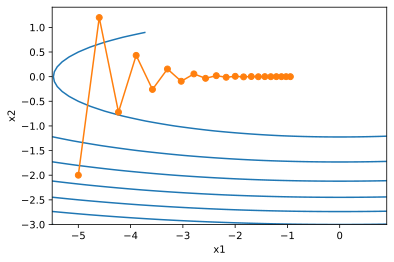

In [22]:
%matplotlib inline
import d2l_pytorch as d2l
import torch

eta = 0.4 # 学习率

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1 -0.387814, x2 -1673.365109


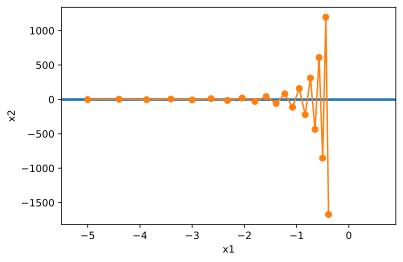

In [23]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

$$
v_t \leftarrow \gamma v_{t-1} + \eta_t g_t \\
x_t \leftarrow x_{t-1} - v_t 
$$

其中$g_t$为随机梯度，$\eta_t$为学习率，$\gamma$为动量超参数。

epoch 20, x1 -0.062843, x2 0.001202


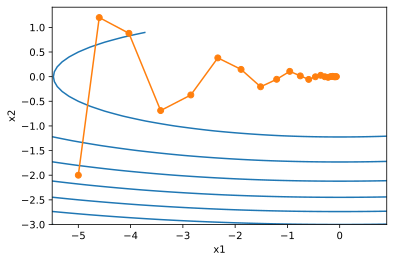

In [24]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1 0.007188, x2 0.002553


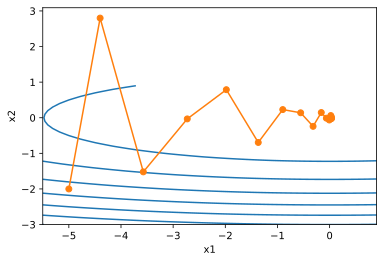

In [25]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

In [26]:
features, labels = d2l.get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

loss: 0.242607, 0.044708 sec per epoch


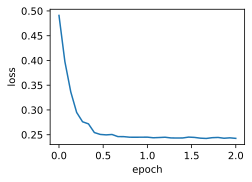

In [27]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr' : 0.02, 'momentum' : 0.5}, features, labels)

loss: 0.255847, 0.049004 sec per epoch


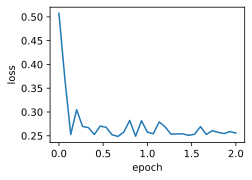

In [28]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr' : 0.02, 'momentum' : 0.9}, features, labels)

loss: 0.247083, 0.044799 sec per epoch


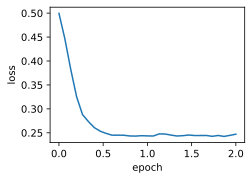

In [29]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr' : 0.004, 'momentum' : 0.9}, features, labels)

loss: 0.243862, 0.044002 sec per epoch


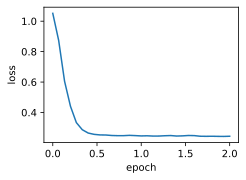

In [30]:
d2l.train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},features, labels)

## AdaGrad算法

$$
s_t \leftarrow s_{t-1} + g_t \odot g_t \\
x_t \leftarrow x_{t-1} - \frac{\eta}{\sqrt{s_t + \delta}} \odot g_t
$$

其中$s_t$为小批量随机梯度$g_t$按元素平方和的累加变量，$\eta$为学习率，$\delta$是为了维持数值稳定性而添加的常数。

当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

epoch 20, x1 -2.382563, x2 -0.158591


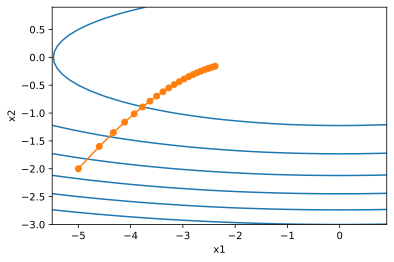

In [31]:
%matplotlib inline
import math
import torch
import d2l_pytorch as d2l

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1 -0.002295, x2 -0.000000


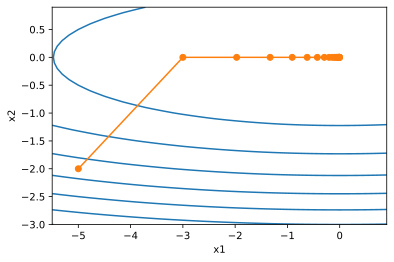

In [32]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

In [33]:
features, labels = d2l.get_data_ch7()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.242816, 0.053030 sec per epoch


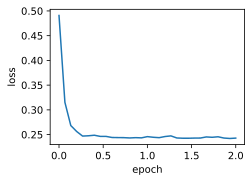

In [34]:
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr' : 0.1}, features, labels)

loss: 0.243301, 0.046647 sec per epoch


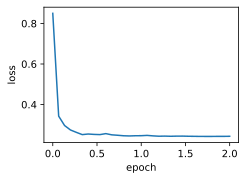

In [35]:
d2l.train_pytorch_ch7(torch.optim.Adagrad, {'lr' : 0.1}, features, labels)

## RMSProp算法

$$
s_t \leftarrow s_{t-1} + g_t \odot g_t \\
x_t \leftarrow x_{t-1} - \frac{\eta}{\sqrt{s_t + \delta}} \odot g_t
$$

RMSProp算法是在AdaGrad算法上的改进，状态变量是对平方项的指数加权平均，所以每个元素的学习率在迭代过程中就不再一直降低或不变。

RMSProp算法和AdaGrad算法的不同在于，RMSProp算法使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率。

epoch 20, x1 -0.010599, x2 0.000000


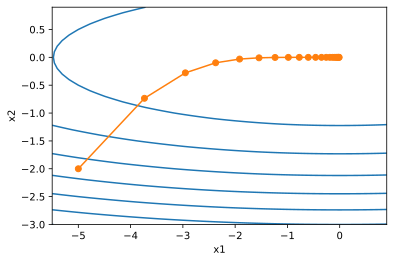

In [36]:
%matplotlib inline
import math
import torch
import d2l_pytorch as d2l

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [37]:
features, labels = d2l.get_data_ch7()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.247532, 0.053391 sec per epoch


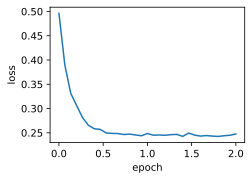

In [38]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9}, features, labels)

loss: 0.246112, 0.050133 sec per epoch


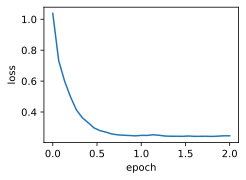

In [39]:
d2l.train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9}, features, labels)

## AdaDelta算法

AdaDelta算法没有学习率超参数，它通过使用有关自变量更新量平方的指数加权移动平均的项来替代RMSProp算法中的学习率。

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$g_t$按元素平方的指数加权移动平均变量$s_t$。在时间步0，它的所有元素被初始化为0。给定超参数0≤ρ<1，在时间步t>0，同RMSProp算法一样计算:

$$
s_t \leftarrow \rho s_{t-1} + (1 - \rho)g_t \odot g_t
$$

与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$Δx_t$，其元素同样在时间步0时被初始化为0。我们使用$Δx_{t−1}$来计算自变量的变化量：

$$
g_t' \leftarrow \sqrt{\frac{\Delta x_{t−1} + \delta}{s_t + \delta}} \odot g_t \\
x_t \leftarrow x_{t-1} - g_t' \\
\Delta x_t \leftarrow \rho \Delta x_{t-1} + (1-\rho)g_t' \odot g_t'
$$

In [40]:
%matplotlib inline
import torch
import d2l_pytorch as d2l

features, labels = d2l.get_data_ch7()

def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g

loss: 0.244009, 0.063684 sec per epoch


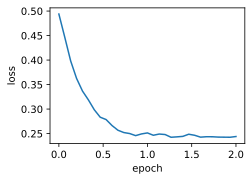

In [41]:
d2l.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

loss: 0.377019, 0.055170 sec per epoch


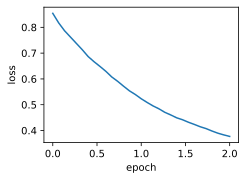

In [42]:
d2l.train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

## Adam算法

Adam算法可以看做是RMSProp算法与动量法的结合。

$$
v_t \leftarrow \beta_1 v_{t-1} + (1-\beta_1)g_t \\
s_t \leftarrow \beta_2 s_{t-1} + (1-\beta_2)g_t \odot g_t \\
\hat{v_t} \leftarrow \frac{v_t}{1-\beta_1^t} \\
\hat{s_t} \leftarrow \frac{s_t}{1-\beta_2^t} \\
g_t' \leftarrow \frac{\eta \hat{v_t}}{\sqrt{\hat{s_t}} + \delta} \\
x_t \leftarrow x_{t-1} - g_t'
$$

In [43]:
%matplotlib inline
import torch
import d2l_pytorch as d2l

features, labels = d2l.get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.243125, 0.066550 sec per epoch


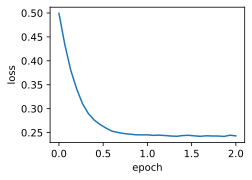

In [44]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

loss: 0.244035, 0.051098 sec per epoch


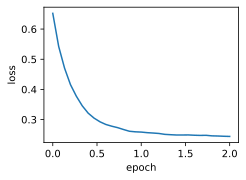

In [45]:
d2l.train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)